# Fraud Detection Project

## Overview
This project aims to detect fraudulent transactions within a financial dataset to enhance security measures and minimize risks. By applying advanced data analysis and machine learning techniques, we will identify patterns and anomalies indicative of fraudulent behavior.

## Datasets
The analysis will leverage several datasets:
- `transactions.csv`: Contains detailed records of transactions processed, including amounts, dates, and user identifiers.
- `users.csv`: Provides information on users, including their demographic data and account details.
- `countries.csv`: Lists country-specific data that could influence transaction validity.
- `currency_details.csv`: Contains details about various currencies used in the transactions.

Data source: https://platform.stratascratch.com/data-projects/fraudsters-detection

## Objectives
1. **Data Exploration**: Conduct an initial exploration to understand the structure and quality of the data.
2. **Feature Engineering**: Develop and refine features that are indicative of fraud.
3. **Model Development**: Build and train machine learning models to predict fraudulent transactions.
4. **Evaluation**: Assess model performance and adjust parameters to improve accuracy.

## Tools and Technologies
- **Python**: The primary programming language used for data manipulation and model building.
- **Pandas & NumPy**: For data manipulation and numerical operations.
- **Scikit-Learn & TensorFlow**: For building and training predictive models.
- **Matplotlib & Seaborn**: For data visualization.

This project not only aims to detect and reduce fraud but also to provide insights that could inform further improvements in transaction processing systems.


In [2]:
#Importing core packages to perform the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



#Packages for model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from dython.nominal import associations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout


#Filters and display options
import warnings
warnings.filterwarnings('ignore')
warnings.warn("text too long")
pd.set_option('display.max_columns', None)
%matplotlib inline


print("Packages loaded")

Packages loaded


### Version tracking
Adding code to check the versions of packages used in this project

In [3]:
import sys
import pkg_resources

#List of commonly used packages
common_packages = [
    'numpy', 'pandas', 'matplotlib', 'sklearn', 'seaborn', 
    'tensorflow', 'dython'
]

#Function to get package version if available
def get_package_version(package_name):
    try:
        return pkg_resources.get_distribution(package_name).version
    except pkg_resources.DistributionNotFound:
        return None

#Print versions of the common packages if they are imported
for package in common_packages:
    if package in sys.modules:
        version = get_package_version(package)
        if version:
            print(f"{package}: {version}")


numpy: 1.26.4
pandas: 1.4.2
matplotlib: 3.9.0
seaborn: 0.13.2
tensorflow: 2.12.0
dython: 0.7.5


### 1. Data Exploration

In this phase of the project we will explore all of the data available to us in order to understand the structure and quality of the data being used for this project. 

In [4]:
#Loading all of the excel files into data frames
countries = pd.read_csv('countries.csv')
currency = pd.read_csv('currency_details.csv')
transactions = pd.read_csv('transactions.csv')
users = pd.read_csv('users.csv')


In [5]:
#Creating a dictionary to hold the dataframes for easier analysis to follow
dataframes = {'transactions': transactions,
              'currency': currency,
              'countries': countries,
              'users': users  
}

In [6]:
#Building a function that will be used to view and summarize the data found in each dataframe
def overview(df, df_name, head=5, tail=5):
   """   
   
   Function to provide an overview of the dataframe being created. 
   
   Args:
      df (DataFrame): DataFrame to be analyzed
      df_name (str): The name of the DataFrame to be displayed
      head : Number of rows to show from the top of the DataFrame
      tail : Number of rows to show from the bottom of the DataFrame
      
   
   """
   print("  NAME   ".center(82, '-'))
   print(df_name)
   
   print("  TYPES   ".center(82, '-'))
   print(df.dtypes)
   
   print("  SHAPE   ".center(82,'-'))
   print(f"Rows: {df.shape[0]}")
   print(f"Columns: {df.shape[1]}")
   
   print("  DUPLICATES  ".center(82,'-'))
   print(df.duplicated().sum())
   
   print("  NaN VALUES  ".center(82,'-'))
   print(df.isna().sum())
   
   #Only comput quantiles for numeric data
   numeric_cols = df.select_dtypes(include=[np.number])
   if not numeric_cols.empty:
      print("  QUANTILES   ".center(82,'-'))
      print(numeric_cols.quantile([0,0.05,0.50,0.95,0.99,1]).T)
   else:
      print("  QUANTILES   ".center(82,'-'))
      print("No numeric columns to display quantiles.")
   
   
   print("  DATAFRAME PREVIEW   ".center(82, '-'))
   print(df.head(n=5))
   print(df.tail(n=5))
   
   

In [7]:
#Loop through the dictionary and apply the function 
results = {}
for name, df in dataframes.items():
    result = overview(df, name)
    results[name] = result
    print(f"Results for {name}:\n{result}\n")

------------------------------------  NAME   -------------------------------------
transactions
------------------------------------  TYPES   ------------------------------------
CURRENCY              object
AMOUNT                 int64
STATE                 object
CREATED_DATE          object
MERCHANT_CATEGORY     object
MERCHANT_COUNTRY      object
ENTRY_METHOD          object
USER_ID               object
TYPE                  object
SOURCE                object
ID                    object
AMOUNT_USD           float64
dtype: object
------------------------------------  SHAPE   ------------------------------------
Rows: 688651
Columns: 12
----------------------------------  DUPLICATES  ----------------------------------
0
----------------------------------  NaN VALUES  ----------------------------------
CURRENCY                  0
AMOUNT                    0
STATE                     0
CREATED_DATE              0
MERCHANT_CATEGORY    465586
MERCHANT_COUNTRY     205596
ENTRY_METHOD   

## Understanding the results output

### Transactions DataFrame:
1. Handling missing values: There are missing values in 'MERCHANT_CATEGORY' and "MERCHANT_COUNTRY' columns. These columns are considered important and the missing values must be handled appropriately.
In order to do this, we're going to do a little feature engineering. By adding binary features indicating whether 'MERCHANT_CATEGORY' or "MERCHANT_COUNTRY' was originally missing, we may be able to leverage these columns in predicting and understanding fraud. 
2. The missing values from this column are also going to be imputed using a model-based imputation approach.

### Currency DataFrame:
1. This dataframe seems straightforward and fairly simple to clean, there are no missing or duplicate values.
2. We'll explore 'EXPONENT' and "IS_CRYPTO' to assess how relevant they are to the analysis 

### Countries DataFrame:
1. There is a missing value in the 'CODE' column which is critical in understanding the data, this will have to be searched and appended.
2. Explore the phone and num codes to further understand the data and if these can aid in joining the data

### Users DataFrame:
1. Handling missing values 'TERMS_VERSION': There are 1,527 missing values in this column which may or may not be relevant to the fraud detection project
2. Feature Engineering:
'PHONE_COUNTRY' and 'COUNTRY' could be used to detect discrepancies (mismatches between the phone and country of residence might indicate risk)

### General Steps
1. Correlation Analysis: After completing the above steps we'll be conducting a correlation analysis to study the different numeric features to see how they relate to each other.
2. Data Integration: Finding ways to integrate all of the datasets together 

In [8]:

#Binary features for missing values
transactions['MERCHANT_CATEGORY_MISSING'] = transactions['MERCHANT_CATEGORY'].isnull().astype(int)
transactions['MERCHANT_COUNTRY_MISSING'] = transactions['MERCHANT_COUNTRY'].isnull().astype(int)

#Fill amount column with median
transactions['AMOUNT_USD'].fillna(transactions['AMOUNT_USD'].median(), inplace=True)


#Initialize LabelEncoders
le_category = LabelEncoder()
le_country = LabelEncoder()

#Fill NaNs with a placeholder before encoding
transactions['MERCHANT_CATEGORY'] = transactions['MERCHANT_CATEGORY'].fillna('missing')
transactions['MERCHANT_COUNTRY'] = transactions['MERCHANT_COUNTRY'].fillna('missing')

#Fit and transform the categorical columns
transactions['MERCHANT_CATEGORY_encoded'] = le_category.fit_transform(transactions['MERCHANT_CATEGORY'])
transactions['MERCHANT_COUNTRY_encoded'] = le_country.fit_transform(transactions['MERCHANT_COUNTRY'])


In [9]:
#Custom function to fill 'missing' placeholders with the most frequent value
def fill_missing_with_mode(df, column, encoded_column, encoder):
    """
    Function to read and fill NaN values in a dataframe, then prepare the dataframe for encoding
    
    Args:
        df (DataFrame): DataFrame with missing values
        encoded_column (str): Column to be encoded
        encoder (object): Encoder used for transforming the dataframe 
        
    Returns:
        df (DataFrame): Returns a dataframe with NaN value placeholders
    
    
    """
    mode_value = df[df[encoded_column] != encoder.transform(['missing'])[0]][encoded_column].mode()[0]
    df[encoded_column] = df[encoded_column].replace(encoder.transform(['missing'])[0], mode_value)
    return df

In [10]:
# Apply custom function to impute missing values
transactions = fill_missing_with_mode(transactions, 'MERCHANT_CATEGORY', 'MERCHANT_CATEGORY_encoded', le_category)
transactions = fill_missing_with_mode(transactions, 'MERCHANT_COUNTRY', 'MERCHANT_COUNTRY_encoded', le_country)

#Check to verify imputation
transactions[['MERCHANT_CATEGORY_encoded', 'MERCHANT_COUNTRY_encoded']].head(30)

,MERCHANT_CATEGORY_encoded,MERCHANT_COUNTRY_encoded
0,85,260
1,85,280
2,5,283
3,85,173
4,85,172
5,91,157
6,85,325
7,91,173
8,85,173
9,111,172


In [11]:
#Decode the imputed values back to the original categories
transactions['MERCHANT_CATEGORY'] = le_category.inverse_transform(transactions['MERCHANT_CATEGORY_encoded'].astype(int))
transactions['MERCHANT_COUNTRY'] = le_country.inverse_transform(transactions['MERCHANT_COUNTRY_encoded'].astype(int))

#Drop the encoded columns
transactions.drop(columns=['MERCHANT_CATEGORY_encoded', 'MERCHANT_COUNTRY_encoded'], inplace=True)

In [12]:
#Checking the dataframe after imputing
transactions.head(30)

,CURRENCY,AMOUNT,STATE,CREATED_DATE,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID,AMOUNT_USD,MERCHANT_CATEGORY_MISSING,MERCHANT_COUNTRY_MISSING
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,point_of_interest,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0,1,0
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,1037.0,0,0
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0,0,0
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,point_of_interest,GBR,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0,1,1
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,point_of_interest,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0,1,0
5,EUR,680,COMPLETED,2017-12-10 16:51:10.791,restaurant,DEU,chip,3c1aa14d-818a-474f-847f-3d24907dd1c7,CARD_PAYMENT,GAIA,99be2b3c-84d7-4522-96b3-8d834e67132f,573.0,0,0
6,USD,357,COMPLETED,2017-12-10 16:50:34.338,point_of_interest,USA,manu,2a6f8724-87e0-481a-8081-a3aed97f48f0,CARD_PAYMENT,GAIA,23144387-74ab-4161-a131-e4b1e7bc86d6,357.0,1,0
7,GBP,6447,COMPLETED,2017-12-10 16:49:30.912,restaurant,GBR,chip,6d8e8a8a-86d3-4291-b2d9-3c6d1a857f5e,CARD_PAYMENT,GAIA,aa1e3dd7-89dd-41a7-bac2-5cd2caae74c3,4767.0,0,0
8,GBP,3335,COMPLETED,2017-12-10 16:48:38.372,point_of_interest,GBR,chip,cbcf5219-8623-4a49-a095-f2797c843b39,CARD_PAYMENT,GAIA,a8679f08-a309-45f3-86c1-2cbc8a9de378,2466.0,1,0
9,EUR,1430,COMPLETED,2017-12-10 16:47:51.308,transit_station,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,f20f926f-8f12-415d-95bb-88cc24f578f7,1206.0,0,0


### Currency DataFrame
Explore 'EXPONENT' and "IS_CRYPTO'

In [13]:
# Explore the 'EXPONENT' column
print(currency['EXPONENT'].value_counts())

# Explore the 'IS_CRYPTO' column
print(currency['IS_CRYPTO'].value_counts())


2    149
0     22
3      7
8      4
4      1
6      1
Name: EXPONENT, dtype: int64
False    179
True       5
Name: IS_CRYPTO, dtype: int64


### Countries DataFrame
Handling missing value in 'CODE' column

In [14]:
# Check for missing values in 'CODE' column
missing_code = countries[countries['CODE'].isnull()]

print(missing_code)


    CODE     NAME CODE3  NUMCODE  PHONECODE
137  NaN  Namibia   nAM      516        264


In [15]:
countries

,CODE,NAME,CODE3,NUMCODE,PHONECODE
0,AF,Afghanistan,AFG,4,93
1,AL,Albania,ALB,8,355
2,DZ,Algeria,DZA,12,213
3,AS,American Samoa,ASM,16,1684
4,AO,Angola,AGO,24,244
...,...,...,...,...,...
221,EH,Western Sahara,eSH,732,212
222,YE,Yemen,yEM,887,967
223,ZM,Zambia,zMB,894,260
224,ZW,Zimbabwe,zWE,716,263


Explore phone and number codes

In [16]:
# Explore phone codes
print(countries['PHONECODE'].describe())

# Explore num codes
print(countries['NUMCODE'].describe())


count     226.000000
mean      531.371681
std       648.237826
min         0.000000
25%       220.250000
50%       354.500000
75%       686.750000
max      7370.000000
Name: PHONECODE, dtype: float64
count    226.000000
mean     433.628319
std      251.971451
min        4.000000
25%      219.000000
50%      432.000000
75%      645.250000
max      894.000000
Name: NUMCODE, dtype: float64


### Users DataFrame
Handling missing values in 'TERMS_VERSION'

In [17]:
# Impute missing values in 'TERMS_VERSION'
users['TERMS_VERSION'].fillna('Unknown', inplace=True)

Feature Engineering


In [18]:
#Create a feature indicating whether 'PHONE_COUNTRY' and 'COUNTRY' are matching
users['PHONE_COUNTRY_MATCH'] = (users['PHONE_COUNTRY'] == users['COUNTRY']).astype(int)


### General Steps:
1. Correlation Analysis

#### Compute the Correlation Matrix
The correlation matrix will help us to understand the relationships between difference numerical features in the data

#### Visualize the Correlation Matrix
We will use a heatmap to visualize the correlation matrix for better understanding




In [19]:
def compute_and_visualize_correlation(df, title="Correlation Matrix"):
    """
    
    Function to compute the correlation matrix and visualize the correlation matrix

    Args:
        df (DataFrame): The pandas DataFrame used in the analysis
        title (str, optional): Title for the correlation matrix created from the function. Defaults to "Correlation Matrix".

    Returns:
       DataFrame: DataFrame and correlation matrix
       
       
    """
    # Compute the correlation matrix
    correlation_results = associations(df, nom_nom_assoc='theil', compute_only=True)
    correlation_matrix = correlation_results['corr']

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))

    # Draw the heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

    # Set title
    plt.title(title)
    
    # Show plot
    plt.show()
    
    return correlation_matrix


The Transactions DataFrame is too large to perform a timely correlation matrix test on. Instead of using 680,000+ rows, we'll be taking a smaller sample size 

In [20]:
#Taking a sample size of the transactions DataFrame
transactions_sample = transactions.sample(n=30000)

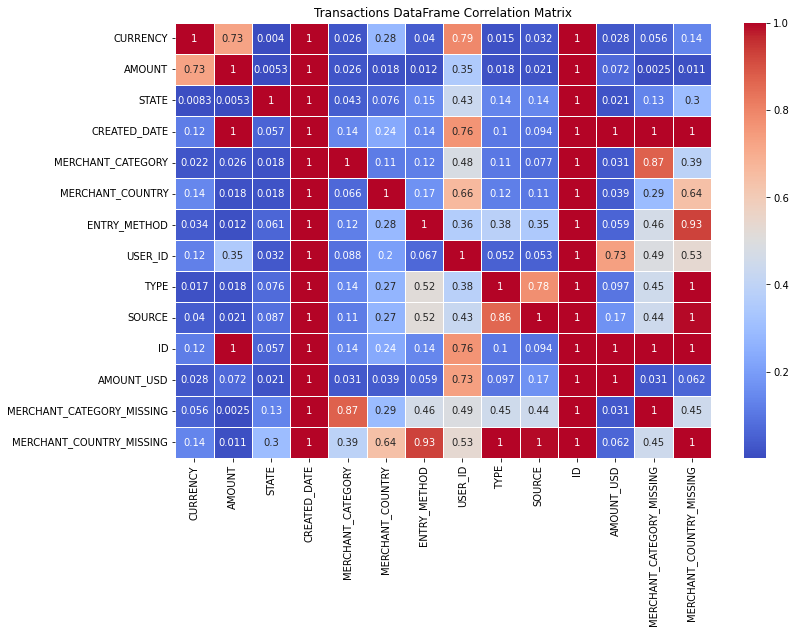

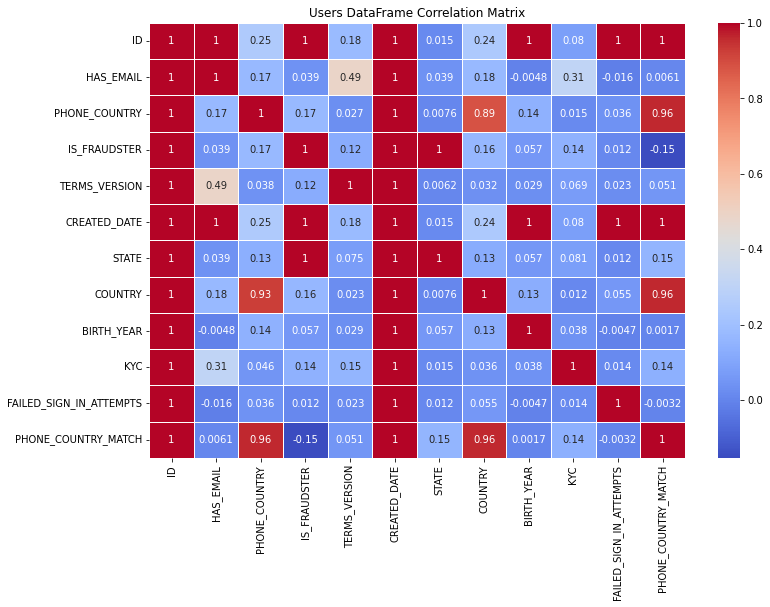

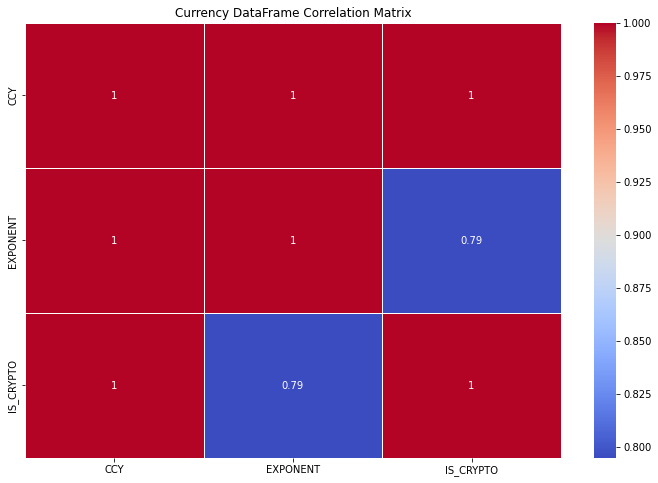

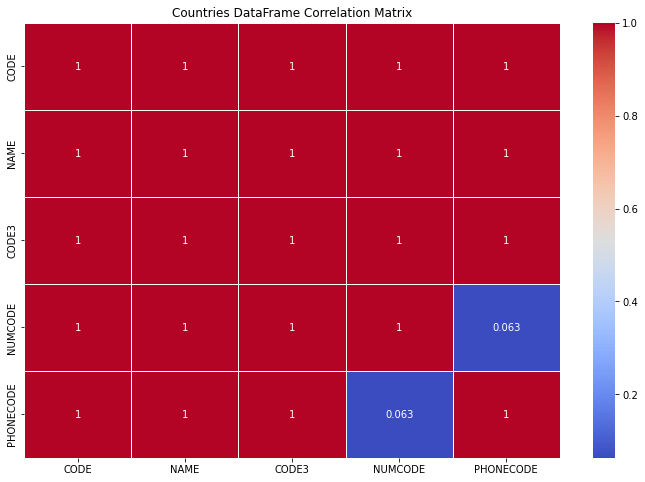

In [21]:
# Compute and visualize correlation matrix for each dataframe
transactions_corr = compute_and_visualize_correlation(transactions_sample, title="Transactions DataFrame Correlation Matrix")
users_corr = compute_and_visualize_correlation(users, title="Users DataFrame Correlation Matrix")
currency_corr = compute_and_visualize_correlation(currency, title="Currency DataFrame Correlation Matrix")
countries_corr = compute_and_visualize_correlation(countries, title="Countries DataFrame Correlation Matrix")


### Summaries for the Correlation Matrices

#### Transactions DataFrame
Transactions Correlation Matrix

The correlation matrix for the Transactions DataFrame reveals the following key insights:

- **High Correlations:**
  - `ID` and `SOURCE` (0.86)
  - `AMOUNT_USD` and `AMOUNT` (0.47)
  - `MERCHANT_CATEGORY_MISSING` and `MERCHANT_CATEGORY` (0.87)
  - `MERCHANT_COUNTRY_MISSING` and `MERCHANT_COUNTRY` (0.93)
  
- **Moderate Correlations:**
  - `USER_ID` and `SOURCE` (0.58)
  - `USER_ID` and `TYPE` (0.48)
  - `USER_ID` and `ID` (0.48)

- **Low Correlations:**
  - Most other feature pairs exhibit low or no correlation.

#### Users DataFrame
Users Correlation Matrix

The correlation matrix for the Users DataFrame highlights the following:

- **High Correlations:**
  - `PHONE_COUNTRY` and `PHONE_COUNTRY_MATCH` (0.96)
  - `PHONE_COUNTRY` and `COUNTRY` (0.93)
  - `ID` and `TERMS_VERSION` (0.49)
  
- **Moderate Correlations:**
  - `KYC` and `TERMS_VERSION` (0.31)
  - `ID` and `KYC` (0.31)

- **Low Correlations:**
  - Other features generally show low or no correlation.

#### Currency DataFrame
![Currency Correlation Matrix](path/to/currency_correlation_matrix.png)

The correlation matrix for the Currency DataFrame indicates:

- **High Correlations:**
  - `CCY` and `EXPONENT` (1.0)
  - `CCY` and `IS_CRYPTO` (1.0)
  - `EXPONENT` and `IS_CRYPTO` (0.79)

- **Low Correlations:**
  - Minimal variability in this dataset; most features have perfect correlation due to limited unique entries.

#### Countries DataFrame
![Countries Correlation Matrix](path/to/countries_correlation_matrix.png)

The correlation matrix for the Countries DataFrame shows:

- **High Correlations:**
  - `CODE`, `NAME`, `CODE3`, and `NUMCODE` are perfectly correlated with each other (1.0)
  - `NUMCODE` and `PHONECODE` (0.063) - the only pair with a slight non-perfect correlation.

### Next Steps

#### 1. **Feature Engineering:**
   - Create new features from existing data that may provide better predictive power. 

#### 2. **Model Building:**
   - Use the cleaned and engineered features to build predictive models using Logistic Regression, Random Forest and Gradient Boosting. 
   - Validate model performance using cross-validation and assess metrics like accuracy, precision, recall, and F1-score.

#### 4. **Further Visualization and Insights:**
   - Conduct deeper exploratory data analysis (EDA) using visualizations to understand distributions, outliers, and other patterns in the data.




2. Data Integration

In [22]:
#Merge datasets using appropriate keys (e.g., 'USER_ID', 'CURRENCY', etc.)
merged_df = pd.merge(transactions, users, how='left', left_on='USER_ID', right_on='ID')

merged_df = pd.merge(merged_df, users[['ID', 'IS_FRAUDSTER']], left_on='USER_ID', right_on='ID', how='left')

#Merge with countries and currency
merged_df = pd.merge(merged_df, countries, how='left', left_on='MERCHANT_COUNTRY', right_on='CODE3')
merged_df = pd.merge(merged_df, currency, how='left', left_on='CURRENCY', right_on='CCY')

#Dropping the redundant columns after merge
merged_df.drop(columns=['ID_y', 'CODE3', 'CCY', 'NAME', 'CODE'], inplace=True)


In [23]:
#Previewing the newly combined dataset
merged_df.head(10)


,CURRENCY,AMOUNT,STATE_x,CREATED_DATE_x,MERCHANT_CATEGORY,MERCHANT_COUNTRY,ENTRY_METHOD,USER_ID,TYPE,SOURCE,ID_x,AMOUNT_USD,MERCHANT_CATEGORY_MISSING,MERCHANT_COUNTRY_MISSING,HAS_EMAIL,PHONE_COUNTRY,IS_FRAUDSTER_x,TERMS_VERSION,CREATED_DATE_y,STATE_y,COUNTRY,BIRTH_YEAR,KYC,FAILED_SIGN_IN_ATTEMPTS,PHONE_COUNTRY_MATCH,ID,IS_FRAUDSTER_y,NUMCODE,PHONECODE,EXPONENT,IS_CRYPTO
0,GBP,4420,COMPLETED,2017-12-10 16:38:55.577,point_of_interest,NLD,chip,3ff52b92-d416-4e22-8cad-018f500d4bbc,ATM,GAIA,367bf5f9-7cce-4683-90b9-d3c011bf4c87,3268.0,1,0,1.0,GB||JE||IM||GG,False,2018-03-20,2017-10-08 12:50:12.794000,ACTIVE,GB,1985.0,PASSED,0.0,0.0,3ff52b92-d416-4e22-8cad-018f500d4bbc,False,NaN,NaN,2,False
1,PLN,1500,COMPLETED,2017-12-10 16:37:24.792,point_of_interest,POL,manu,76cbaad3-4721-4a3b-92b9-3eb9e9319565,CARD_PAYMENT,GAIA,ff6802b9-360d-4efe-b09b-f99c6cac3383,1037.0,0,0,1.0,PL,False,2018-03-20,2017-11-16 17:38:12.378000,ACTIVE,PL,1976.0,PASSED,0.0,1.0,76cbaad3-4721-4a3b-92b9-3eb9e9319565,False,NaN,NaN,2,False
2,GBP,191,COMPLETED,2017-12-10 16:37:16.234,airport,PRT,chip,7bcaa34e-b889-4582-9c29-0b3bab34fb8c,CARD_PAYMENT,GAIA,ddb4a930-7d8a-4f38-9079-ddc4b0db980e,141.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False
3,GBP,10000,COMPLETED,2017-12-10 16:34:42.592,point_of_interest,GBR,misc,b3a6762b-a940-4459-bb1d-8e28e151f901,TOPUP,HERA,080ef0be-850a-4f14-ab03-28ff68e6b797,7394.0,1,1,1.0,GB||JE||IM||GG,False,2018-01-01,2017-07-10 11:50:36.688000,ACTIVE,GB,1992.0,PASSED,0.0,0.0,b3a6762b-a940-4459-bb1d-8e28e151f901,False,NaN,NaN,2,False
4,EUR,1159,COMPLETED,2017-12-10 16:34:17.88,point_of_interest,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,bd13abac-4004-4c67-9bb7-90a42b027e82,977.0,1,0,1.0,FR,False,2018-09-20,2016-07-28 00:26:52.447000,ACTIVE,FR,1990.0,PASSED,0.0,1.0,f5723f5e-5a00-4851-ae1d-5c11146aa491,False,250.0,33.0,2,False
5,EUR,680,COMPLETED,2017-12-10 16:51:10.791,restaurant,DEU,chip,3c1aa14d-818a-474f-847f-3d24907dd1c7,CARD_PAYMENT,GAIA,99be2b3c-84d7-4522-96b3-8d834e67132f,573.0,0,0,1.0,HU,False,2018-09-20,2017-05-31 06:48:35.014000,ACTIVE,HU,1978.0,PASSED,0.0,1.0,3c1aa14d-818a-474f-847f-3d24907dd1c7,False,276.0,49.0,2,False
6,USD,357,COMPLETED,2017-12-10 16:50:34.338,point_of_interest,USA,manu,2a6f8724-87e0-481a-8081-a3aed97f48f0,CARD_PAYMENT,GAIA,23144387-74ab-4161-a131-e4b1e7bc86d6,357.0,1,0,1.0,DE,False,2018-03-20,2016-02-03 22:11:12.445000,ACTIVE,DE,1982.0,PASSED,0.0,1.0,2a6f8724-87e0-481a-8081-a3aed97f48f0,False,NaN,NaN,2,False
7,GBP,6447,COMPLETED,2017-12-10 16:49:30.912,restaurant,GBR,chip,6d8e8a8a-86d3-4291-b2d9-3c6d1a857f5e,CARD_PAYMENT,GAIA,aa1e3dd7-89dd-41a7-bac2-5cd2caae74c3,4767.0,0,0,1.0,GB||JE||IM||GG,False,2018-09-20,2017-09-19 12:07:19.352000,ACTIVE,GB,1987.0,PASSED,0.0,0.0,6d8e8a8a-86d3-4291-b2d9-3c6d1a857f5e,False,NaN,NaN,2,False
8,GBP,3335,COMPLETED,2017-12-10 16:48:38.372,point_of_interest,GBR,chip,cbcf5219-8623-4a49-a095-f2797c843b39,CARD_PAYMENT,GAIA,a8679f08-a309-45f3-86c1-2cbc8a9de378,2466.0,1,0,1.0,PT,False,2018-03-20,2017-10-25 05:02:20.216000,ACTIVE,PT,1985.0,PASSED,0.0,1.0,cbcf5219-8623-4a49-a095-f2797c843b39,False,NaN,NaN,2,False
9,EUR,1430,COMPLETED,2017-12-10 16:47:51.308,transit_station,FRA,manu,f5723f5e-5a00-4851-ae1d-5c11146aa491,CARD_PAYMENT,GAIA,f20f926f-8f12-415d-95bb-88cc24f578f7,1206.0,0,0,1.0,FR,False,2018-09-20,2016-07-28 00:26:52.447000,ACTIVE,FR,1990.0,PASSED,0.0,1.0,f5723f5e-5a00-4851-ae1d-5c11146aa491,False,250.0,33.0,2,False


In [24]:
#Drop columns with NaN values
columns_to_check = [
    'HAS_EMAIL', 'PHONE_COUNTRY', 'TERMS_VERSION', 
    'CREATED_DATE_y', 'STATE_y', 'COUNTRY', 'BIRTH_YEAR', 'KYC', 
    'FAILED_SIGN_IN_ATTEMPTS', 'PHONE_COUNTRY_MATCH'
]
merged_df.drop(columns=columns_to_check, inplace=True)

In [25]:
#Fill NaNs in NUMCODE and PHONECODE with median
merged_df['NUMCODE'].fillna(merged_df['NUMCODE'].median(), inplace=True)
merged_df['PHONECODE'].fillna(merged_df['PHONECODE'].median(), inplace=True)


In [26]:
#Dropping excess columns that are no longer needed after merging the datasets
merged_df.dropna(subset=['IS_FRAUDSTER_x', 'ID', 'IS_FRAUDSTER_y'], inplace=True)


In [27]:
#Taking a final review of the data before moving onto preprocessing and modeling 
merged_df.isna().sum()

CURRENCY                     0
AMOUNT                       0
STATE_x                      0
CREATED_DATE_x               0
MERCHANT_CATEGORY            0
MERCHANT_COUNTRY             0
ENTRY_METHOD                 0
USER_ID                      0
TYPE                         0
SOURCE                       0
ID_x                         0
AMOUNT_USD                   0
MERCHANT_CATEGORY_MISSING    0
MERCHANT_COUNTRY_MISSING     0
IS_FRAUDSTER_x               0
ID                           0
IS_FRAUDSTER_y               0
NUMCODE                      0
PHONECODE                    0
EXPONENT                     0
IS_CRYPTO                    0
dtype: int64

The code executed in the Preprocessing and Modeling Steps failed to catch the data type of the 'IS_FRAUDSTER_x' column, the code below converts the boolean values in the column to int type so the column can be used in modeling. 

In [28]:
#Converting the target column 'IS_FRAUDSTER_x' from boolean to int
merged_df['IS_FRAUDSTER_x'] = merged_df['IS_FRAUDSTER_x'].astype(int)

## Preprocessing and Modeling Steps

### Splitting Data into Features and Target
The first step of the code block below splits the dataset into features('X') and the target variable ('y'). The target variable is 'IS_FRAUDSTER_x' which indicates whether a transaction is fraudulent or not.

### Preprocessing for Numerical and Categorical Features
In this step, we prepare the data for modeling by preprocessing the numberical and categorical features.
* Numerical Features: We use 'StandardScaler' to standardize the numberical features so that they have a mean of 0 and a standard deviation of 1.
* Categorical Features: We use 'OneHotEncoder' to convert categorical features into a format that can be provided to machine learning algorithms to do a better job in prediction. The 'handle_unknown='ignore'' parameter ensures that any previously unseen categories during the encoding phase will be ignored

The 'ColumnTransform' is used to apply these transformations to the respective columns in the combined dataaset.


### Splitting the data
Here we split the data into training and testing sets using an 80-20 split. The 'random_state=42' ensures that the split is reproducible. These are standard split and random_state sizes.

### Logistic Regression
In this step, we create a pipeline for the Logistic Regression model. The pipeline includes the preprocessing steps followed by the logistic regression classifier. The model is then fitted on the training data and the predicted using the test data. The accuracy of the model is calculated using 'accuracy_score'.

### Random Forest
Similary, a pipeline is created for the Random Forest classifier. The pipeline includes the preprocessing steps followed by the Random Forest classifier. WE fit the model on the training data, predict on the test data, and calculate the accuracy.

### Gradient Boosting
Finally, a pipline is created for the Gradient Boosting classifier. The pipeline includes the preprocessing steps followed by the Gradient Boosting classifier.

In [29]:
#Splitting data into features and target
X = merged_df.drop(columns=['IS_FRAUDSTER_x'])
y = merged_df['IS_FRAUDSTER_x']

#Preprocessing for numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Logistic Regression
logreg = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression())])
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, y_pred_logreg)

#Random Forest
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', RandomForestClassifier())])
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

#Gradient Boosting
gb = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', GradientBoostingClassifier())])
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
gb_acc = accuracy_score(y_test, y_pred_gb)


In [30]:
#Printing the results
print(f'Logistic Regression Accuracy: {logreg_acc}')
print(f'Random Forest Accuracy: {rf_acc}')
print(f'Gradient Boosting Accuracy: {gb_acc}')

Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 1.0
Gradient Boosting Accuracy: 1.0


## Model Performance Results

After training and evaluating three different machine learning models on our dataset, we achieved the following accuracy scores:

- **Logistic Regression Accuracy**: 1.0
- **Random Forest Accuracy**: 1.0
- **Gradient Boosting Accuracy**: 1.0

### Interpretation of Results

All three models (Logistic Regression, Random Forest, and Gradient Boosting) achieved an accuracy score of 1.0, indicating perfect prediction on the test data. This result suggests that the models have learned to classify the data very well.

### Summary of Models

1. **Logistic Regression**:
    - A simple yet powerful linear model used for binary classification.
    - Achieved perfect accuracy on our test set, suggesting that the relationship between the features and the target variable can be well captured by a linear decision boundary.

2. **Random Forest**:
    - An ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes (classification) of the individual trees.
    - The model's perfect accuracy indicates that the multiple trees in the forest successfully capture the complex patterns in the data.

3. **Gradient Boosting**:
    - Another ensemble learning technique that builds the model in a stage-wise fashion from multiple weak learners (typically decision trees) and optimizes for accuracy by minimizing the loss function.
    - The high accuracy score implies that the model effectively reduces the prediction errors through iterative training.

### Next Steps

Given the perfect accuracy scores, it's crucial to ensure that the models are not overfitting. Different tests to consider in the future:

- **Receiver Operating Characteristic - Area Under Curve (ROC  AUC)**: Provides an aggregate measure of performance across all classification thresholds.
- **Confusion Matrix**: Visualizes the number of correct and incorrect predictions made by each model.
- **Cross-Validation**: Apply cross-validation to assess the model's performance on different subsets of the data to confirm its generalization ability.
- **Further Testing**: Use an additional, independent dataset to validate the model's performance.

The current results are highly promising, but these additional steps will help confirm the robustness and generalizability of the models.


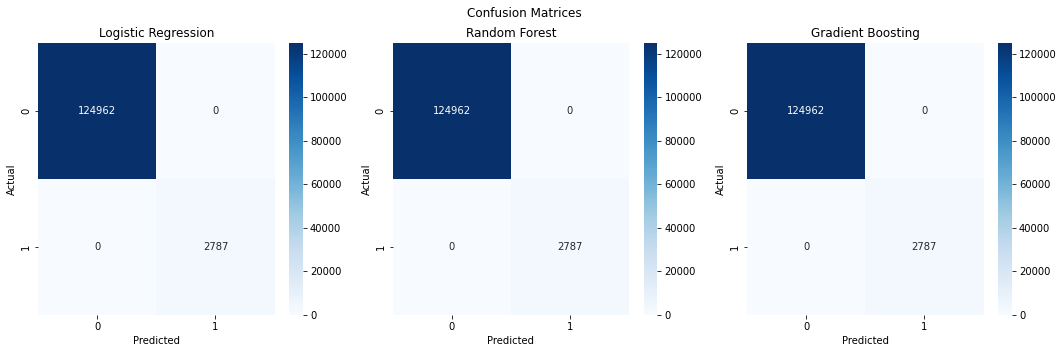

Logistic Regression ROC AUC Score: 1.0000
Random Forest ROC AUC Score: 1.0000
Gradient Boosting ROC AUC Score: 1.0000


In [36]:
#Logistic Regression
y_pred_logreg = logreg.predict(X_test)
logreg_cm = confusion_matrix(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

#Random Forest
y_pred_rf = rf.predict(X_test)
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

#Gradient Boosting
y_pred_gb = gb.predict(X_test)
gb_cm = confusion_matrix(y_test, y_pred_gb)
gb_roc_auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])

#Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices')

sns.heatmap(logreg_cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(rf_cm, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(gb_cm, annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Gradient Boosting')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.show()

#Print ROC AUC scores
print(f'Logistic Regression ROC AUC Score: {logreg_roc_auc:.4f}')
print(f'Random Forest ROC AUC Score: {rf_roc_auc:.4f}')
print(f'Gradient Boosting ROC AUC Score: {gb_roc_auc:.4f}')

The results indicate that all models have achieved perfect accuracy and ROC AUC scores of 1.0000. This might be due to the following reasons:

* Data Imbalance: The dataset might have imbalanced classes, leading to models that predict the majority class correctly.
* Overfitting: The models might be overfitting to the training data, capturing noise and patterns that do not generalize well to new data


In [37]:
#Number of cross-validation folds
cv_folds = 5

#Logistic Regression Cross-Validation
logreg_cv_scores = cross_val_score(logreg, X, y, cv=cv_folds, scoring='accuracy')

#Random Forest Cross-Validation
rf_cv_scores = cross_val_score(rf, X, y, cv=cv_folds, scoring='accuracy')

#Gradient Boosting Cross-Validation
gb_cv_scores = cross_val_score(gb, X, y, cv=cv_folds, scoring='accuracy')

#Print cross-validation results
print(f'Logistic Regression Cross-Validation Scores: {logreg_cv_scores}')
print(f'Logistic Regression Mean Accuracy: {logreg_cv_scores.mean():.4f}')

print(f'Random Forest Cross-Validation Scores: {rf_cv_scores}')
print(f'Random Forest Mean Accuracy: {rf_cv_scores.mean():.4f}')

print(f'Gradient Boosting Cross-Validation Scores: {gb_cv_scores}')
print(f'Gradient Boosting Mean Accuracy: {gb_cv_scores.mean():.4f}')

Logistic Regression Cross-Validation Scores: [1. 1. 1. 1. 1.]
Logistic Regression Mean Accuracy: 1.0000
Random Forest Cross-Validation Scores: [1. 1. 1. 1. 1.]
Random Forest Mean Accuracy: 1.0000
Gradient Boosting Cross-Validation Scores: [1. 1. 1. 1. 1.]
Gradient Boosting Mean Accuracy: 1.0000


## Deep Learning Model Training

### Convert Categorical Variables to Numerical Using One-Hot Encoding
In this step, we apply one-hot encoding to the categorical variables in our dataset. This is done using the ColumnTransformer which combines StandardScaler for numerical features and OneHotEncoder for categorical features. The resulting X_preprocessed is a transformed dataset with numerical and one-hot encoded categorical values.

### Split the Data into Training and Testing Sets
Here, we split the preprocessed data into training and testing sets. We use an 80-20 split ratio, ensuring that 80% of the data is used for training and 20% is used for testing. The random_state=42 ensures reproducibility of the split.

### Create Explicit Validation Set
To evaluate the model during training, we create a validation set by further splitting the training data into training and validation sets. This helps us monitor the model's performance on unseen data during training.

### Convert Target Variable to Categorical
We convert the target variable (y) into a categorical format using the to_categorical function from Keras. This is necessary for the multi-class classification task.

### Convert Sparse Matrix to Sparse Tensor
To handle the large size of the data efficiently, we define a function sparse_matrix_to_sparse_tensor that converts a SciPy sparse matrix to a TensorFlow sparse tensor. This conversion is necessary because TensorFlow can process sparse tensors more efficiently without running into memory issues.

### Build and Complie the Deep Learning Model
We build a deep learning model using the Keras Sequential API. The model consists of several dense layers with ReLU activation functions and dropout layers to prevent overfitting. The final layer uses the softmax activation function for multi-class classification. We compile the model with the adam optimizer and categorical_crossentropy loss function.

1. Sequential API:

The Keras Sequential API is used to create a linear stack of layers. This means we add one layer at a time, starting from the input layer and ending with the output layer.

2. Input Layer:

Dense(128, activation='relu', input_shape=(X_train.shape[1],))
This layer is a fully connected (dense) layer with 128 neurons.
input_shape=(X_train.shape[1],) specifies the shape of the input data. Each sample in X_train has X_train.shape[1] features.
activation='relu' specifies the activation function used in this layer. ReLU (Rectified Linear Unit) activation helps to introduce non-linearity into the model, allowing it to learn more complex patterns.

3. Dropout Layer:

Dropout(0.3)
Dropout is a regularization technique used to prevent overfitting.
It randomly sets 30% (0.3) of the input units to 0 at each update during training time, which helps prevent the model from becoming too dependent on any particular neurons.

4. Hidden Layers:

Dense(64, activation='relu') and Dense(32, activation='relu')
These are additional fully connected layers with 64 and 32 neurons, respectively.
Each layer uses the ReLU activation function to introduce non-linearity.

5. Additional Dropout Layers:

Dropout(0.3) after each hidden layer.
These dropout layers help to further regularize the model and prevent overfitting.

6. Output Layer:

Dense(y_train.shape[1], activation='softmax')
The final layer is a fully connected layer with a number of neurons equal to the number of classes in the target variable (y_train.shape[1]).
activation='softmax' is used for multi-class classification. The softmax function outputs a probability distribution over the classes, with each value between 0 and 1, and the sum of all values equal to 1.

7. Compiling the Model:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Optimizer: optimizer='adam'
Adam (Adaptive Moment Estimation) is an optimization algorithm that adjusts the learning rate for each parameter. It combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.
Loss Function: loss='categorical_crossentropy'
Categorical Crossentropy is used as the loss function for multi-class classification problems. It measures the difference between the true label distribution and the predicted label distribution.
Metrics: metrics=['accuracy']
Accuracy is used as a metric to evaluate the model’s performance. It calculates the percentage of correct predictions.

### Training the Model
Prepare the training and validation datasets using the tf.data.Dataset API, which allows efficient batching and shuffling of data. The model is then trained for 50 epochs with a batch size of 32. The training history, including training and validation loss and accuracy, is stored in the history object.

### Evaluating the Model
Finally, evaluate the trained model on the test dataset to determine its accuracy on unseen data. The test data is also prepared using the tf.data.Dataset API. The evaluation results are printed, showing the model's accuracy on the test set.

In [38]:
# #Convert categorical variables to numerical using one-hot encoding
# X_preprocessed = preprocessor.fit_transform(X)

# #Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# #Create explicit validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# #Convert target variable to categorical
# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# y_test = to_categorical(y_test)

# # Function to convert sparse matrix to sparse tensor
# def sparse_matrix_to_sparse_tensor(sparse_matrix):
#     """
    
    
#     """
#     coo = sparse_matrix.tocoo()
#     indices = np.mat([coo.row, coo.col]).transpose()
#     return tf.SparseTensor(indices, coo.data, coo.shape)

# # Convert sparse matrices to sparse tensors for the deep learning model
# X_train = sparse_matrix_to_sparse_tensor(X_train)
# X_val = sparse_matrix_to_sparse_tensor(X_val)
# X_test = sparse_matrix_to_sparse_tensor(X_test)
# #Building the deep learning model
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dropout(0.3),
#     Dense(y_train.shape[1], activation='softmax')
# ])

# #Compiling the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #Training
# batch_size = 16
# epochs = 10

# #Dataset preparation
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# #Trainning the model
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)


# # Evaluating the model
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
# loss, accuracy = model.evaluate(test_dataset)
# print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10
   34/25550 [..............................] - ETA: 6:36:03 - loss: 0.3717 - accuracy: 0.9559

KeyboardInterrupt: 

Logistic Regression: 1.0000
Random Forest: 1.0000
Gradient Boosting: 1.0000


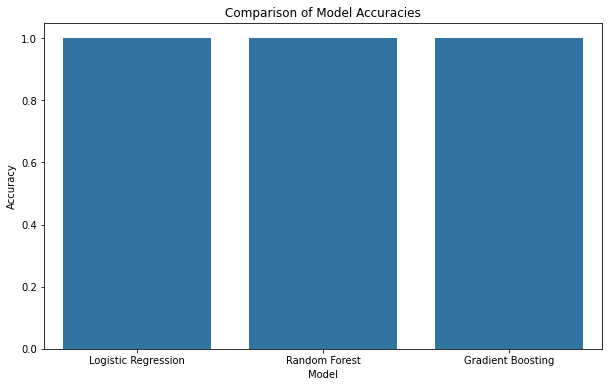

In [39]:
#Collecting the accuracy results
results = {
    'Logistic Regression': logreg_acc,
    'Random Forest': rf_acc,
    'Gradient Boosting': gb_acc,
    #'Deep Learning': accuracy
}

#Displaying the results
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

#Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()
